In [1]:
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as accuracy
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def sentence_embedding_lookup(train_data):
    ''' Lookup sentence embedding using tf_hub'''
    module = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1")
    
    module(train_data)
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = np.array(session.run(module(inputs=train_data)))
        
    return embeddings

In [2]:
def dataset_prep_reg():
    ''' Read data from a csv file and use keras preprocessing to create 
    data matrix with sequence of integers for each sentence padded with 
    zeros'''
    tokenizer = Tokenizer()
    # Read data from csv file
    df = pd.read_csv("C:/Users/SODIQ-PC/Desktop/Capstone_1819/turk_data.csv",sep=',')

    # Extract the response column from data
    data = df['turk_response_text']
    label = np.array(df[['1','2','3']])
    
    y1 = label[:,0]
    y2 = label[:,1]
    y3 = label[:,2]
    
    # convert each sentence to a string and make all data into a list
    corpus = [str(data[i]).lower() for i in range(len(data))]
    
    #tokenize the corpus removing punctuations and get unique vocabulary of of corpus
    tokenizer.fit_on_texts(corpus)
    
    corpus_emb = sentence_embedding_lookup(corpus)
    
    # split data into train and test set
    x1_train, x1_test, y1_train, y1_test = train_test_split(corpus_emb, y1, test_size=0.2, random_state=10)
    # split data into train and test set
    x2_train, x2_test, y2_train, y2_test = train_test_split(corpus_emb, y2, test_size=0.2, random_state=10)
    # split data into train and test set
    x3_train, x3_test, y3_train, y3_test = train_test_split(corpus_emb, y3, test_size=0.2, random_state=10)

    return x1_train, x1_test, y1_train, y1_test

In [39]:
def create_model(train_data):
    '''Create a baseline model using DNN regression '''
    model = Sequential()
    model.add(Dense(units = 512, activation = 'relu', input_dim = train_data.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(units = 10, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    #compile model
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_squared_error'])
    
    return model

In [5]:
x1_train, x1_test, y1_train, y1_test = dataset_prep_reg()

INFO:tensorflow:Using C:\Users\SODIQ-PC\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
x1_train[:5]

array([[ 4.90219116e-01,  8.55127797e-02,  1.35206953e-01,
         1.79620519e-01,  9.19984952e-02, -2.64803320e-02,
         6.17542937e-02, -1.35534346e-01, -6.32471517e-02,
         1.74567886e-02,  1.02215987e-02, -1.07701704e-01,
         1.04338536e-02, -1.87209398e-01, -7.08149001e-02,
         4.47419249e-02,  4.69313636e-02,  7.14493021e-02,
        -9.01800320e-02,  3.83826256e-01,  8.11571553e-02,
         3.26292776e-02,  9.32676867e-02, -7.64712989e-02,
         1.30555496e-01,  1.16024399e-02,  2.88532693e-02,
         1.88991383e-01, -1.19975299e-01,  1.02182321e-01,
         2.28446275e-02, -5.92820570e-02,  1.75765574e-01,
         2.30525985e-01,  1.90289188e-02,  9.65670776e-03,
        -1.75568223e-01, -1.04571357e-01,  1.00492932e-01,
         1.49767056e-01, -9.64104291e-03, -5.91125004e-02,
        -1.39639109e-01, -1.65391222e-01,  1.24252751e-01,
         2.32812643e-01,  8.42568800e-02, -8.04309472e-02,
        -2.35629212e-02, -9.65854302e-02,  6.78411797e-0

In [7]:
y1_train[:5]

array([3, 5, 3, 5, 1], dtype=int64)

In [40]:
# Initialize model
model = create_model(x1_train)

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 71,189
Trainable params: 71,189
Non-trainable params: 0
_________________________________________________________________


In [42]:
#define criteria for early stop
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# Train model
training = model.fit(x1_train, y1_train, validation_split = 0.2,
                     epochs=1000, callbacks=[early_stop])

Train on 1068 samples, validate on 268 samples
Epoch 1/1000
1068/1068 [==============================] - 0s 405us/step - loss: 3.5358 - mean_squared_error: 3.5358 - val_loss: 2.1366 - val_mean_squared_error: 2.1366
Epoch 2/1000
1068/1068 [==============================] - 0s 104us/step - loss: 2.5506 - mean_squared_error: 2.5506 - val_loss: 1.7840 - val_mean_squared_error: 1.7840
Epoch 3/1000
 640/1068 [================>.............] - ETA: 0s - loss: 2.1129 - mean_squared_error: 2.1129

C:\Users\SODIQ-PC\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: mean_squared_error,loss,val_mean_squared_error,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1068/1068 [==============================] - 0s 100us/step - loss: 2.1129 - mean_squared_error: 2.1129 - val_loss: 1.5709 - val_mean_squared_error: 1.5709
Epoch 4/1000
1068/1068 [==============================] - 0s 118us/step - loss: 1.9543 - mean_squared_error: 1.9543 - val_loss: 1.3190 - val_mean_squared_error: 1.3190
Epoch 5/1000
1068/1068 [==============================] - 0s 102us/step - loss: 2.0189 - mean_squared_error: 2.0189 - val_loss: 1.2045 - val_mean_squared_error: 1.2045
Epoch 6/1000
1068/1068 [==============================] - 0s 98us/step - loss: 1.7777 - mean_squared_error: 1.7777 - val_loss: 1.2025 - val_mean_squared_error: 1.2025
Epoch 7/1000
1068/1068 [==============================] - 0s 98us/step - loss: 1.8183 - mean_squared_error: 1.8183 - val_loss: 1.2874 - val_mean_squared_error: 1.2874
Epoch 8/1000
1068/1068 [==============================] - 0s 95us/step - loss: 1.7307 - mean_squared_error: 1.7307 - val_loss: 1.1447 - val_mean_squared_error: 1.1447
Epoch 9/

Epoch 52/1000
1068/1068 [==============================] - 0s 107us/step - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.8376 - val_mean_squared_error: 0.8376
Epoch 53/1000
1068/1068 [==============================] - 0s 106us/step - loss: 0.6045 - mean_squared_error: 0.6045 - val_loss: 0.9070 - val_mean_squared_error: 0.9070
Epoch 54/1000
1068/1068 [==============================] - 0s 115us/step - loss: 0.6010 - mean_squared_error: 0.6010 - val_loss: 0.8060 - val_mean_squared_error: 0.8060
Epoch 55/1000
1068/1068 [==============================] - 0s 104us/step - loss: 0.6225 - mean_squared_error: 0.6225 - val_loss: 0.8049 - val_mean_squared_error: 0.8049
Epoch 56/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.5578 - mean_squared_error: 0.5578 - val_loss: 0.8227 - val_mean_squared_error: 0.8227
Epoch 57/1000
1068/1068 [==============================] - 0s 132us/step - loss: 0.4974 - mean_squared_error: 0.4974 - val_loss: 0.8118 - val_mean_squared_e

1068/1068 [==============================] - 0s 105us/step - loss: 0.4355 - mean_squared_error: 0.4355 - val_loss: 0.7947 - val_mean_squared_error: 0.7947
Epoch 101/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.3962 - mean_squared_error: 0.3962 - val_loss: 0.8146 - val_mean_squared_error: 0.8146
Epoch 102/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.4336 - mean_squared_error: 0.4336 - val_loss: 0.8375 - val_mean_squared_error: 0.8375
Epoch 103/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3952 - mean_squared_error: 0.3952 - val_loss: 0.8008 - val_mean_squared_error: 0.8008
Epoch 104/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.4435 - mean_squared_error: 0.4435 - val_loss: 0.7884 - val_mean_squared_error: 0.7884
Epoch 105/1000
1068/1068 [==============================] - 0s 104us/step - loss: 0.4517 - mean_squared_error: 0.4517 - val_loss: 0.7818 - val_mean_squared_error: 0.7818

1068/1068 [==============================] - 0s 118us/step - loss: 0.3634 - mean_squared_error: 0.3634 - val_loss: 0.7752 - val_mean_squared_error: 0.7752
Epoch 149/1000
1068/1068 [==============================] - 0s 107us/step - loss: 0.3739 - mean_squared_error: 0.3739 - val_loss: 0.7725 - val_mean_squared_error: 0.7725
Epoch 150/1000
1068/1068 [==============================] - 0s 106us/step - loss: 0.3348 - mean_squared_error: 0.3348 - val_loss: 0.7965 - val_mean_squared_error: 0.7965
Epoch 151/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3637 - mean_squared_error: 0.3637 - val_loss: 0.7415 - val_mean_squared_error: 0.7415
Epoch 152/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3389 - mean_squared_error: 0.3389 - val_loss: 0.7669 - val_mean_squared_error: 0.7669
Epoch 153/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3680 - mean_squared_error: 0.3680 - val_loss: 0.7828 - val_mean_squared_error: 0.782

1068/1068 [==============================] - 0s 102us/step - loss: 0.3364 - mean_squared_error: 0.3364 - val_loss: 0.7444 - val_mean_squared_error: 0.7444
Epoch 197/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3601 - mean_squared_error: 0.3601 - val_loss: 0.7462 - val_mean_squared_error: 0.7462
Epoch 198/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3444 - mean_squared_error: 0.3444 - val_loss: 0.7870 - val_mean_squared_error: 0.7870
Epoch 199/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3751 - mean_squared_error: 0.3751 - val_loss: 0.7759 - val_mean_squared_error: 0.7759
Epoch 200/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3819 - mean_squared_error: 0.3819 - val_loss: 0.7627 - val_mean_squared_error: 0.7627
Epoch 201/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3868 - mean_squared_error: 0.3868 - val_loss: 0.7747 - val_mean_squared_error: 0.7747


1068/1068 [==============================] - 0s 104us/step - loss: 0.3511 - mean_squared_error: 0.3511 - val_loss: 0.7579 - val_mean_squared_error: 0.7579
Epoch 245/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.7567 - val_mean_squared_error: 0.7567
Epoch 246/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3511 - mean_squared_error: 0.3511 - val_loss: 0.7578 - val_mean_squared_error: 0.7578
Epoch 247/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3222 - mean_squared_error: 0.3222 - val_loss: 0.7296 - val_mean_squared_error: 0.7296
Epoch 248/1000
1068/1068 [==============================] - 0s 100us/step - loss: 0.3755 - mean_squared_error: 0.3755 - val_loss: 0.7493 - val_mean_squared_error: 0.7493
Epoch 249/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3482 - mean_squared_error: 0.3482 - val_loss: 0.7431 - val_mean_squared_error: 0.7431

1068/1068 [==============================] - 0s 98us/step - loss: 0.3640 - mean_squared_error: 0.3640 - val_loss: 0.7345 - val_mean_squared_error: 0.7345
Epoch 293/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.3535 - mean_squared_error: 0.3535 - val_loss: 0.7340 - val_mean_squared_error: 0.7340
Epoch 294/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3235 - mean_squared_error: 0.3235 - val_loss: 0.7322 - val_mean_squared_error: 0.7322
Epoch 295/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3307 - mean_squared_error: 0.3307 - val_loss: 0.7260 - val_mean_squared_error: 0.7260
Epoch 296/1000
1068/1068 [==============================] - 0s 100us/step - loss: 0.3430 - mean_squared_error: 0.3430 - val_loss: 0.7782 - val_mean_squared_error: 0.7782
Epoch 297/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3600 - mean_squared_error: 0.3600 - val_loss: 0.8037 - val_mean_squared_error: 0.8037


1068/1068 [==============================] - 0s 96us/step - loss: 0.3737 - mean_squared_error: 0.3737 - val_loss: 0.7422 - val_mean_squared_error: 0.7422
Epoch 341/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3499 - mean_squared_error: 0.3499 - val_loss: 0.7304 - val_mean_squared_error: 0.7304
Epoch 342/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.3643 - mean_squared_error: 0.3643 - val_loss: 0.7567 - val_mean_squared_error: 0.7567
Epoch 343/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3744 - mean_squared_error: 0.3744 - val_loss: 0.7151 - val_mean_squared_error: 0.7151
Epoch 344/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.4038 - mean_squared_error: 0.4038 - val_loss: 0.7556 - val_mean_squared_error: 0.7556
Epoch 345/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.7086 - val_mean_squared_error: 0.7086
E

1068/1068 [==============================] - 0s 101us/step - loss: 0.3404 - mean_squared_error: 0.3404 - val_loss: 0.7662 - val_mean_squared_error: 0.7662
Epoch 389/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3334 - mean_squared_error: 0.3334 - val_loss: 0.7241 - val_mean_squared_error: 0.7241
Epoch 390/1000
1068/1068 [==============================] - 0s 105us/step - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.7505 - val_mean_squared_error: 0.7505
Epoch 391/1000
1068/1068 [==============================] - 0s 107us/step - loss: 0.3204 - mean_squared_error: 0.3204 - val_loss: 0.7610 - val_mean_squared_error: 0.7610
Epoch 392/1000
1068/1068 [==============================] - 0s 106us/step - loss: 0.3546 - mean_squared_error: 0.3546 - val_loss: 0.7754 - val_mean_squared_error: 0.7754
Epoch 393/1000
1068/1068 [==============================] - 0s 106us/step - loss: 0.3431 - mean_squared_error: 0.3431 - val_loss: 0.7745 - val_mean_squared_error: 0.7

1068/1068 [==============================] - 0s 100us/step - loss: 0.3232 - mean_squared_error: 0.3232 - val_loss: 0.7450 - val_mean_squared_error: 0.7450
Epoch 437/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.7626 - val_mean_squared_error: 0.7626
Epoch 438/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3215 - mean_squared_error: 0.3215 - val_loss: 0.7436 - val_mean_squared_error: 0.7436
Epoch 439/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3538 - mean_squared_error: 0.3538 - val_loss: 0.7464 - val_mean_squared_error: 0.7464
Epoch 440/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3327 - mean_squared_error: 0.3327 - val_loss: 0.7672 - val_mean_squared_error: 0.7672
Epoch 441/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3237 - mean_squared_error: 0.3237 - val_loss: 0.7421 - val_mean_squared_error: 0.7421


1068/1068 [==============================] - 0s 96us/step - loss: 0.3461 - mean_squared_error: 0.3461 - val_loss: 0.7528 - val_mean_squared_error: 0.7528
Epoch 485/1000
1068/1068 [==============================] - 0s 108us/step - loss: 0.3213 - mean_squared_error: 0.3213 - val_loss: 0.7444 - val_mean_squared_error: 0.7444
Epoch 486/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3708 - mean_squared_error: 0.3708 - val_loss: 0.7314 - val_mean_squared_error: 0.7314
Epoch 487/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3566 - mean_squared_error: 0.3566 - val_loss: 0.7662 - val_mean_squared_error: 0.7662
Epoch 488/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3212 - mean_squared_error: 0.3212 - val_loss: 0.7731 - val_mean_squared_error: 0.7731
Epoch 489/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3349 - mean_squared_error: 0.3349 - val_loss: 0.7332 - val_mean_squared_error: 0.7332


1068/1068 [==============================] - 0s 98us/step - loss: 0.3061 - mean_squared_error: 0.3061 - val_loss: 0.7646 - val_mean_squared_error: 0.7646
Epoch 533/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3817 - mean_squared_error: 0.3817 - val_loss: 0.7163 - val_mean_squared_error: 0.7163
Epoch 534/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3792 - mean_squared_error: 0.3792 - val_loss: 0.7250 - val_mean_squared_error: 0.7250
Epoch 535/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3478 - mean_squared_error: 0.3478 - val_loss: 0.7491 - val_mean_squared_error: 0.7491
Epoch 536/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.3405 - mean_squared_error: 0.3405 - val_loss: 0.7226 - val_mean_squared_error: 0.7226
Epoch 537/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3502 - mean_squared_error: 0.3502 - val_loss: 0.7349 - val_mean_squared_error: 0.7349
E

1068/1068 [==============================] - 0s 119us/step - loss: 0.3128 - mean_squared_error: 0.3128 - val_loss: 0.7370 - val_mean_squared_error: 0.7370
Epoch 581/1000
1068/1068 [==============================] - 0s 117us/step - loss: 0.3470 - mean_squared_error: 0.3470 - val_loss: 0.7348 - val_mean_squared_error: 0.7348
Epoch 582/1000
1068/1068 [==============================] - 0s 107us/step - loss: 0.3326 - mean_squared_error: 0.3326 - val_loss: 0.7324 - val_mean_squared_error: 0.7324
Epoch 583/1000
1068/1068 [==============================] - 0s 120us/step - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.7344 - val_mean_squared_error: 0.7344
Epoch 584/1000
1068/1068 [==============================] - 0s 116us/step - loss: 0.3543 - mean_squared_error: 0.3543 - val_loss: 0.7038 - val_mean_squared_error: 0.7038
Epoch 585/1000
1068/1068 [==============================] - 0s 105us/step - loss: 0.3136 - mean_squared_error: 0.3136 - val_loss: 0.7093 - val_mean_squared_error: 0.

1068/1068 [==============================] - 0s 98us/step - loss: 0.3072 - mean_squared_error: 0.3072 - val_loss: 0.7206 - val_mean_squared_error: 0.7206
Epoch 629/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3178 - mean_squared_error: 0.3178 - val_loss: 0.7784 - val_mean_squared_error: 0.7784
Epoch 630/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3014 - mean_squared_error: 0.3014 - val_loss: 0.7205 - val_mean_squared_error: 0.7205
Epoch 631/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.3295 - mean_squared_error: 0.3295 - val_loss: 0.7087 - val_mean_squared_error: 0.7087
Epoch 632/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3251 - mean_squared_error: 0.3251 - val_loss: 0.7232 - val_mean_squared_error: 0.7232
Epoch 633/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3340 - mean_squared_error: 0.3340 - val_loss: 0.7174 - val_mean_squared_error: 0.7174
E

1068/1068 [==============================] - 0s 94us/step - loss: 0.3376 - mean_squared_error: 0.3376 - val_loss: 0.7470 - val_mean_squared_error: 0.7470
Epoch 677/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3229 - mean_squared_error: 0.3229 - val_loss: 0.7217 - val_mean_squared_error: 0.7217
Epoch 678/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3273 - mean_squared_error: 0.3273 - val_loss: 0.7015 - val_mean_squared_error: 0.7015
Epoch 679/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3436 - mean_squared_error: 0.3436 - val_loss: 0.7033 - val_mean_squared_error: 0.7033
Epoch 680/1000
1068/1068 [==============================] - 0s 102us/step - loss: 0.3842 - mean_squared_error: 0.3842 - val_loss: 0.6948 - val_mean_squared_error: 0.6948
Epoch 681/1000
1068/1068 [==============================] - 0s 106us/step - loss: 0.3185 - mean_squared_error: 0.3185 - val_loss: 0.7200 - val_mean_squared_error: 0.7200

1068/1068 [==============================] - 0s 98us/step - loss: 0.3332 - mean_squared_error: 0.3332 - val_loss: 0.7130 - val_mean_squared_error: 0.7130
Epoch 725/1000
1068/1068 [==============================] - 0s 92us/step - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 0.7259 - val_mean_squared_error: 0.7259
Epoch 726/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3304 - mean_squared_error: 0.3304 - val_loss: 0.7494 - val_mean_squared_error: 0.7494
Epoch 727/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3469 - mean_squared_error: 0.3469 - val_loss: 0.7424 - val_mean_squared_error: 0.7424
Epoch 728/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3452 - mean_squared_error: 0.3452 - val_loss: 0.7429 - val_mean_squared_error: 0.7429
Epoch 729/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.7305 - val_mean_squared_error: 0.7305
E

1068/1068 [==============================] - 0s 102us/step - loss: 0.3656 - mean_squared_error: 0.3656 - val_loss: 0.7174 - val_mean_squared_error: 0.7174
Epoch 773/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3292 - mean_squared_error: 0.3292 - val_loss: 0.7335 - val_mean_squared_error: 0.7335
Epoch 774/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3507 - mean_squared_error: 0.3507 - val_loss: 0.7085 - val_mean_squared_error: 0.7085
Epoch 775/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3681 - mean_squared_error: 0.3681 - val_loss: 0.7124 - val_mean_squared_error: 0.7124
Epoch 776/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3488 - mean_squared_error: 0.3488 - val_loss: 0.7324 - val_mean_squared_error: 0.7324
Epoch 777/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.7311 - val_mean_squared_error: 0.7311


1068/1068 [==============================] - 0s 107us/step - loss: 0.3489 - mean_squared_error: 0.3489 - val_loss: 0.7398 - val_mean_squared_error: 0.7398
Epoch 821/1000
1068/1068 [==============================] - 0s 101us/step - loss: 0.3394 - mean_squared_error: 0.3394 - val_loss: 0.7174 - val_mean_squared_error: 0.7174
Epoch 822/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3193 - mean_squared_error: 0.3193 - val_loss: 0.7306 - val_mean_squared_error: 0.7306
Epoch 823/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3100 - mean_squared_error: 0.3100 - val_loss: 0.7394 - val_mean_squared_error: 0.7394
Epoch 824/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3394 - mean_squared_error: 0.3394 - val_loss: 0.7179 - val_mean_squared_error: 0.7179
Epoch 825/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3350 - mean_squared_error: 0.3350 - val_loss: 0.7478 - val_mean_squared_error: 0.7478

1068/1068 [==============================] - 0s 101us/step - loss: 0.3317 - mean_squared_error: 0.3317 - val_loss: 0.7601 - val_mean_squared_error: 0.7601
Epoch 869/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3398 - mean_squared_error: 0.3398 - val_loss: 0.7360 - val_mean_squared_error: 0.7360
Epoch 870/1000
1068/1068 [==============================] - 0s 103us/step - loss: 0.3117 - mean_squared_error: 0.3117 - val_loss: 0.7495 - val_mean_squared_error: 0.7495
Epoch 871/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3366 - mean_squared_error: 0.3366 - val_loss: 0.7497 - val_mean_squared_error: 0.7497
Epoch 872/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3257 - mean_squared_error: 0.3257 - val_loss: 0.7437 - val_mean_squared_error: 0.7437
Epoch 873/1000
1068/1068 [==============================] - 0s 97us/step - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.7315 - val_mean_squared_error: 0.7315

1068/1068 [==============================] - 0s 121us/step - loss: 0.3238 - mean_squared_error: 0.3238 - val_loss: 0.7728 - val_mean_squared_error: 0.7728
Epoch 917/1000
1068/1068 [==============================] - 0s 103us/step - loss: 0.3065 - mean_squared_error: 0.3065 - val_loss: 0.7249 - val_mean_squared_error: 0.7249
Epoch 918/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.3450 - mean_squared_error: 0.3450 - val_loss: 0.7173 - val_mean_squared_error: 0.7173
Epoch 919/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.2979 - mean_squared_error: 0.2979 - val_loss: 0.7108 - val_mean_squared_error: 0.7108
Epoch 920/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3703 - mean_squared_error: 0.3703 - val_loss: 0.7134 - val_mean_squared_error: 0.7134
Epoch 921/1000
1068/1068 [==============================] - 0s 93us/step - loss: 0.2846 - mean_squared_error: 0.2846 - val_loss: 0.7494 - val_mean_squared_error: 0.7494

1068/1068 [==============================] - 0s 100us/step - loss: 0.3554 - mean_squared_error: 0.3554 - val_loss: 0.7184 - val_mean_squared_error: 0.7184
Epoch 965/1000
1068/1068 [==============================] - 0s 96us/step - loss: 0.3252 - mean_squared_error: 0.3252 - val_loss: 0.7371 - val_mean_squared_error: 0.7371
Epoch 966/1000
1068/1068 [==============================] - 0s 94us/step - loss: 0.3054 - mean_squared_error: 0.3054 - val_loss: 0.7261 - val_mean_squared_error: 0.7261
Epoch 967/1000
1068/1068 [==============================] - 0s 95us/step - loss: 0.2847 - mean_squared_error: 0.2847 - val_loss: 0.7465 - val_mean_squared_error: 0.7465
Epoch 968/1000
1068/1068 [==============================] - 0s 98us/step - loss: 0.3530 - mean_squared_error: 0.3530 - val_loss: 0.7106 - val_mean_squared_error: 0.7106
Epoch 969/1000
1068/1068 [==============================] - 0s 99us/step - loss: 0.3165 - mean_squared_error: 0.3165 - val_loss: 0.7482 - val_mean_squared_error: 0.7482


In [44]:
# make predictions on the test set using trained model
y_pred = model.predict(x1_test)

In [53]:
#Mean_Squared_Error = MSE(y1_test, y_pred)
print("model mean_squared_error on test: {}".format(Mean_Squared_Error))

model mean_squared_error on test: 0.7850274475605569


In [51]:
from sklearn.metrics import mean_squared_error as MSE

In [34]:
print(training.history.keys())

dict_keys(['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss'])


Text(0,0.5,'MSE')

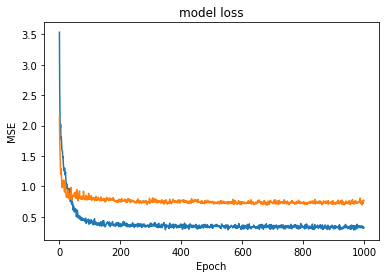

In [43]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [56]:
y_pred[:10]

array([[2.8202658],
       [1.5246687],
       [1.4007584],
       [1.4027826],
       [1.323352 ],
       [2.188153 ],
       [1.9676558],
       [1.2451184],
       [3.7565417],
       [2.9050188]], dtype=float32)

In [57]:
y1_test[:10]

array([3, 1, 1, 1, 1, 1, 2, 1, 5, 3], dtype=int64)